In [1]:
import h5py
from datahandler import *

## Set parameters

### Ploting parameters

In [2]:
# Set global plot parameters
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.titlepad'] = 10  # Adjust title padding if necessary
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 0.25
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['black'])
plt.rcParams['legend.fontsize'] = 6

### Set file directory

In [3]:
path = r'\\research.files.med.harvard.edu\Neurobio\Fishell Lab\Shuhan_HMS folder\NGFC\2P\NGFC' 
folder = r'\NP11_DlxCre;Lamp5FlpO;Ai195\NP11U\NP11U_ROI4_121222'
directory_path = path + folder

### Set specific parameters

In [4]:
image_filename = r'\NP11U_ROI4_image1'
speed_filename = r'\NP11U_ROI4_speed1.npy'
behavior_filename = r'\NP11U_ROI4_record1_proc.npy'
VIDEO_FRAMERATE = 19.06 #Hz
BASE_DEPTH = -59
DELTA_Z = 50
GCAMP='7s'

### Set stimulation 
**stimuli_type = A**: dark spontaneous with **stimuli** = 'np.nan'</br>  
**stimuli_type = B**: gray spontaneous with **stimuli** = 'np.nan'</br>  

In [5]:
stimuli_type = 'A' 
stimuli = 'np.nan' # nan - spontaneous

---
## Process imaging data
Imaging data were 30Hz calcium imaging from Suite2P

Output files: dict_keys(['F.npy', 'Fneu.npy', 'iscell.npy', 'ops.npy', 'spks.npy', 'stat.npy'])
Shape of 'FwithFneu': (108, 22000)
Shape of 'Fneu': (108, 22000)
Shape of 'iscell': (108, 2)
Type of 'ops': <class 'dict'>
Shape of 'spks': (108, 22000)
spike deconvolution is not used in all data, so 'spks' maybe empty or miscalculated.
shape of 'F':  (21, 22000)
Number of ROI/cells: num_roi = 21
Index of detected cells (ROIs): ind_cells = 
 [ 0  1  2  4  5  6  7  8  9 10 11 13 14 15 16 22 24 25 32 53 69]
location of detected cells (y,x,depth): 'roi_loc_with_depths' = 
 [[ 289.          131.          -43.54011742]
 [ 385.          127.          -33.7553816 ]
 [ 253.           55.          -39.62622309]
 [ 313.          335.          -61.15264188]
 [ 337.          179.          -43.54011742]
 [ 365.           19.          -25.14481409]
 [ 313.          287.          -56.45596869]
 [ 457.          139.          -27.88454012]
 [ 337.          339.          -59.19569472]
 [ 105.          399.  

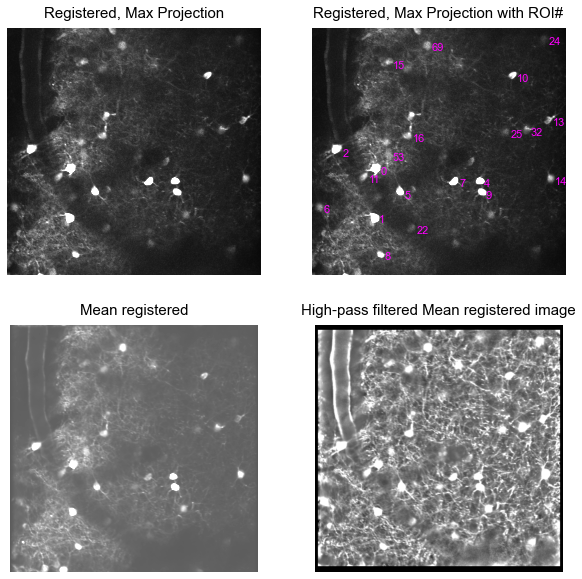

In [6]:
CalciumData = CalciumDataHandler(directory_path, 
                                  image_filename, 
                                  base_depth=BASE_DEPTH, 
                                  delta_z=DELTA_Z, 
                                  gcamp_type=GCAMP, 
                                  print_info=True, 
                                  file_format='tif')

[F, FwithFneu, Fneu, iscell, ops, spks, stat, 
 # F has substracted Fneu * neurophil factor
 roi_loc, stat_orig, ind_cells, num_roi] = CalciumData.read_Suite2p()


### Get standardized_dF_F0, baseline F0, dF_F0 and check the signal quality of each ROIs

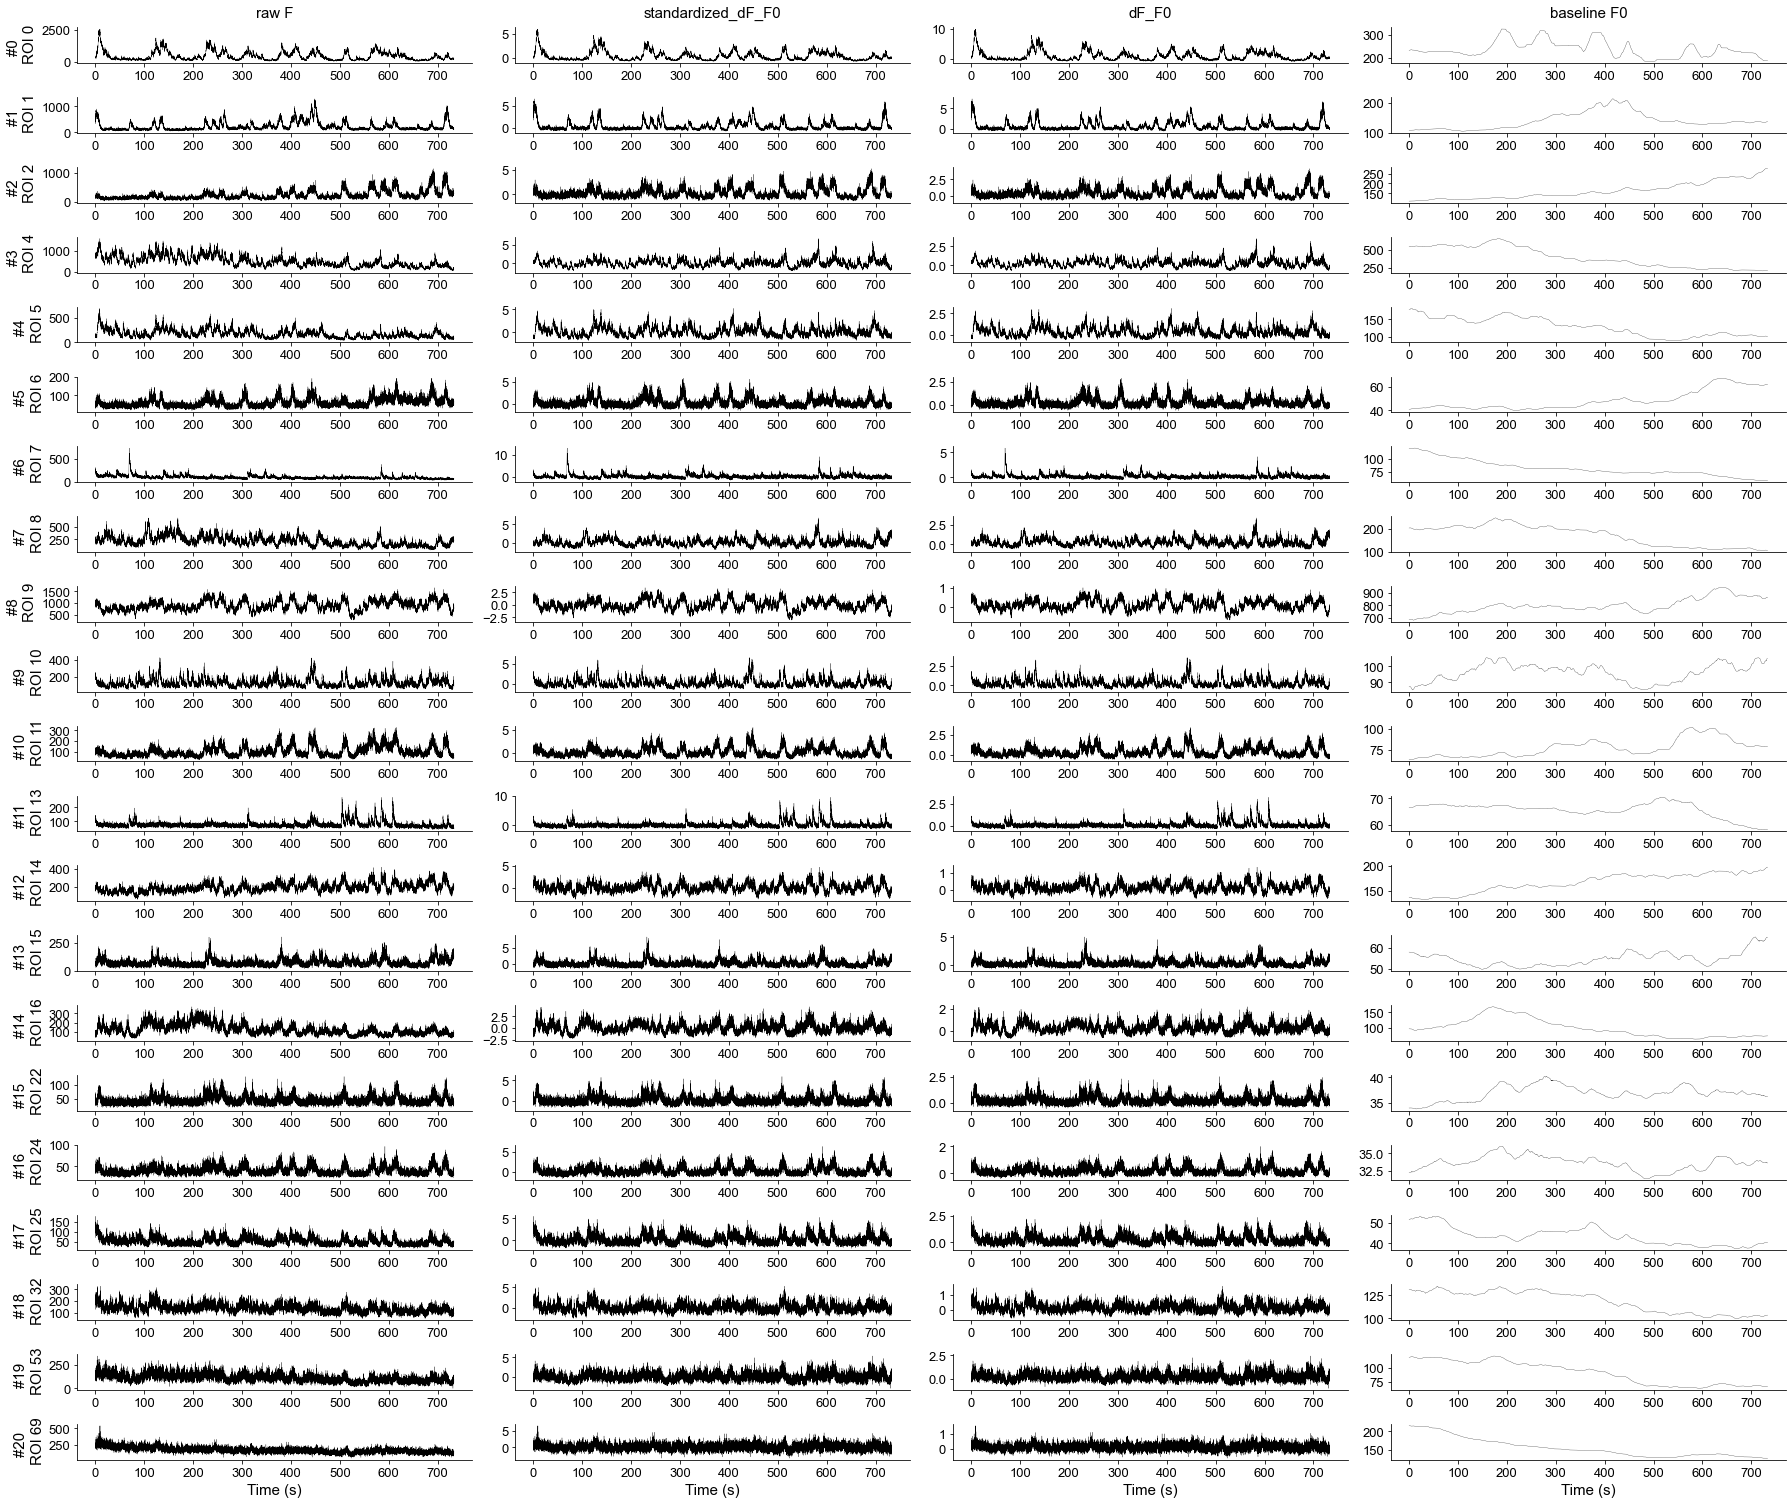

In [7]:
standardized_dF_F0, F0, dF_F0 = CalciumData.standard_dF_F0(window_size=150, # 150-s window
                                                           percentile=30, 
                                                           plot=True)

---
## Process speed data
Speed data from wheels, preprocessed, smoothed via **convolve1d** with uniform weighting (ones) filter with full-length window, and saved as .npy file in **[1] ReadSpeed mat to npy.ipynb**

#### Binning speed to 30Hz as imaging frame rate, transform to cm/s

shape of 'binned speed'= (21900,)


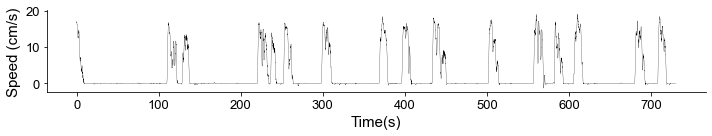

In [8]:
SpeedData = SpeedDataHandler(directory_path, 
                             speed_filename,
                             add_one=True, 
                             file_format='tif')

speed = SpeedData.binning_speed()

---
## Process behavior data
Behavior data from Facemap: 

(1) **motion_SVD** (raw from facemap, unsmoothed), 

(2) **video_running** (raw from facemap, unsmoothed), 

(3) **merged_blinks** (detect blinks with deviation period added before and after blink, and merge nearby blinks), <br/> 
**timestamps** (For each blink, four equally spaced time points are required. t2 is the blink onset; t3 is
the blink offset; t1=t2-t3+t2; t4=t3-t2+t3),

(4) **blink_zscored** (blink data raw from facemap, after z-score), <br/>
**blink_zscored_smooth_velocity** (velocity of smoothed blink z-score data),

(5) **pupil_area_smooth** (raw from facemap), <br/> 
**pupil_zscored** (after z-score), <br/> 
**pupil_nan** (after replacing blinks with NaN on pupil_zscored), <br/> 
**pupil_nan_smooth** (smoothed **pupil_nan**), <br/>
**pupil_interpolated** (Based on these **timestamps** and the associated pupil sizes (from the original, unsmoothed signal), a cubic-spline fit is generated. The original signal between t2 and t3 is replaced by the cubic spline. Thus, the signal is left unchanged, except for the blink period), <br/>
**pupil_interpolated_smooth** (Smoothed **pupil_interpolated**)

(6) **pupil_com** (center of mass in pixel, substracted from mean), <br/> 
**pupil_com_nan** (after replacing blink with NaN), <br/> 
**pupil_com_nan_smooth** (smoothed **pupil_com_nan**), <br/>
**pupil_com_interpolated** (with cubic-spline interpolation), <br/> 
**pupil_com_interpolated_smooth**(Smoothed **pupil_com_interpolated**)

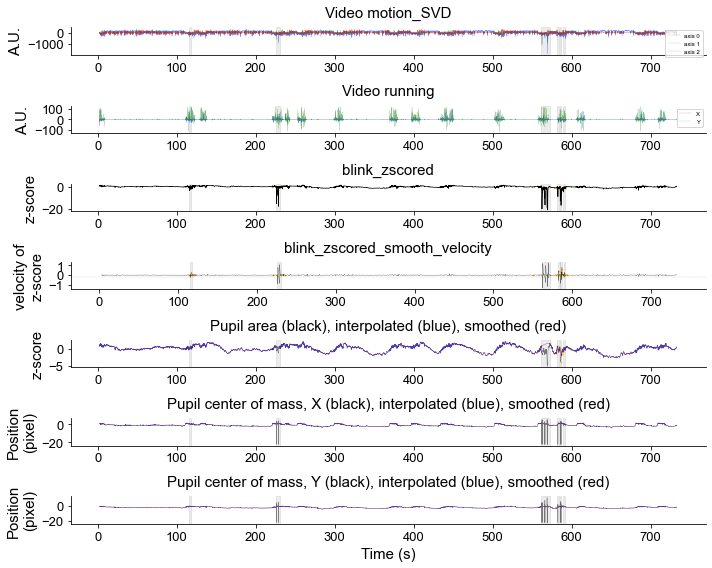

In [9]:
BehaviorData = BehaviorDataHandler(directory_path, 
                                   behavior_filename, 
                                   VIDEO_FRAMERATE, 
                                   window_size=19,
                                   velocity_threshold=-0.2,
                                   zero_threshold=0.02,
                                   deviation_onset=5,
                                   deviation_offset=15,
                                   merge_threshold=10,
                                   y_lim=None,
                                   file_format='tif')

[video_motSVD, 
 video_running,
 merged_blinks, timestamps, 
 blink_zscored, blink_zscored_smooth_velocity,
 pupil_area_smooth, pupil_zscored, 
 pupil_nan, pupil_nan_smooth, 
 pupil_interpolated, pupil_interpolated_smooth,
 pupil_com, 
 pupil_com_nan, pupil_com_nan_smooth, 
 pupil_com_interpolated, pupil_com_interpolated_smooth] = BehaviorData.read_video()

# plot the data to check
BehaviorData.plot_video()

---
## Save processed data for downstream analysis
Data from suite2p processing are stored in suite2p folder, so they are not saved here.

In [10]:
data_to_save = {
    'roi_loc': roi_loc, # (y, x, z)
    'ind_cells': ind_cells,
    'num_roi': num_roi,
    
    # Imaging data are all 30Hz
    'F': F, # F has substracted Fneu * neurophil factor
    'F0': F0, # baseline
    'dF_F0': dF_F0,
    'standardized_dF_F0': standardized_dF_F0, # ∆F/F0 traces were standardized by subtracting the median and dividing by the standard deviation.
    
    # Speed data saved as 30Hz
    'speed': speed, # smoothed and binned speed (30Hz), in cm/s

    # Video data are saved as original VIDEO_FRAMERATE.
    'VIDEO_FRAMERATE': VIDEO_FRAMERATE, # confirm the frame_rate of videos
    'video_motSVD': video_motSVD, # (frames, 500) Nose and face region (raw from facemap, unsmoothed)
    'video_running': video_running, # (frames, 2) running speed from video (raw from facemap, unsmoothed)

    'merged_blinks': merged_blinks, # (each blink, 2) 2-on and off; the on and off frame index for each blink
    'timestamps': timestamps, # (four data points for each blink)
    'blink_zscored': blink_zscored, # (frames,) z-scored blink data
    'blink_zscored_smooth_velocity': blink_zscored_smooth_velocity, # velocity of smoothed blink_zscored
    
    'pupil_area_smooth': pupil_area_smooth, # list of pupil area_smooth outputs from Facemap
    'pupil_zscored': pupil_zscored, # pupil_area_smooth after z-score
    'pupil_nan': pupil_nan, # pupil_area_zscored after replacing blinks + deviation periods with NaN
    'pupil_nan_smooth': pupil_nan_smooth,
    'pupil_interpolated': pupil_interpolated, # pupil_zscored with CubicSpline interpolation
    'pupil_interpolated_smooth': pupil_interpolated_smooth,
    
    'pupil_com': pupil_com, # pixel, center of mass, substracted from mean
    'pupil_com_nan': pupil_com_nan, # pupil_com after replacing blinks + deviation periods with NaN
    'pupil_com_nan_smooth': pupil_com_nan_smooth,
    'pupil_com_interpolated': pupil_com_interpolated, # pupil_com_nan with 1d interpolation
    'pupil_com_interpolated_smooth': pupil_com_interpolated_smooth,

    'stimuli_type': stimuli_type,
    'stimuli': stimuli
}

# Define the path for the HDF5 file
hdf5_file_path = directory_path + image_filename +'_data.h5' 

# Create a new HDF5 file
with h5py.File(hdf5_file_path, 'w') as h5f:
    # Loop over the data and save each dataset
    for key, value in data_to_save.items():
        h5f.create_dataset(key, data=value)